In [1]:
# Documentation: https://research.donorschoose.org/t/download-opendata/33
from __future__ import division
# import ml
# reload(ml)
# from ml import *
# import rfpimp
# reload(rfpimp)
# from rfpimp import *
import timeit
import scipy
import operator
import numpy as np
import pandas as pd
# import cPickle as pickle
from scipy import stats
import seaborn as sns
from tqdm import tqdm_notebook
from datetime import datetime
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from pprint import pprint

import statsmodels.api as sm
from sklearn.utils import resample
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('classic')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Methods

In [2]:
def cov(arr):
    return np.std(arr) / np.mean(arr) 

def fundingTime(arr):
    return (arr.max() - arr.min()).days

def interEventTime(arr):
    return [(t - s).seconds for s, t in zip(sorted(arr), sorted(arr)[1:])]

def avgInterEventTime(arr):
    return np.mean(interEventTime(arr))

def covInterEventTime(arr):
    varr = interEventTime(arr)
    return np.std(varr) / np.mean(varr) 

# Initialize Label Encoder
le = LabelEncoder()

## Donations

In [16]:
donations = pd.read_csv('../Data/donations.gz', escapechar='\\', names=['_donationid', '_projectid', '_donor_acctid', '_cartid', 'donor_city', 'donor_state', 'donor_zip', 'is_teacher_acct', 'donation_timestamp', 'donation_to_project', 'donation_optional_support', 'donation_total', 'donation_included_optional_support', 'payment_method', 'payment_included_acct_credit', 'payment_included_campaign_gift_card', 'payment_included_web_purchased_gift_card', 'payment_was_promo_matched', 'is_teacher_referred', 'giving_page_id', 'giving_page_type', 'for_honoree', 'thank_you_packet_mailed'])
# Filter relevant columns
columns = ["_donationid", "_projectid", "_donor_acctid", "donation_timestamp", "donation_total", "payment_method"]
donations = donations[columns]
# Convert donation timestamp to datetime format
donations["donation_timestamp"] = pd.to_datetime(donations.donation_timestamp)
# Variable /YYYY/MM to allow monthly time unit analysis
donations["time_trunc"] = donations.donation_timestamp.map(lambda x: x.strftime('%Y%m')) 
# List of project_ids for projects that received re-allocated funds
filtered = list(set(donations[donations.payment_method == 'no_cash_received']["_projectid"]))
# Exclude these donations for donation level analysis
donations = donations[donations.payment_method != 'no_cash_received'] 
# Drop temporary column
donations = donations.drop(['payment_method'], axis=1)
# Show sample data
donations.sample(5)

,_donationid,_projectid,_donor_acctid,donation_timestamp,donation_total,time_trunc
2150577,589cff3f11f4be8af6de2cd7c7e95d49,75583a4c7f8b690788ff7a5d3035411c,8ea3e134ca71d9dc877664b2f04fcef8,2015-05-17 19:36:19.162,1.000,201505
5857021,f15d50f616bdb2607feae14427d02c41,0c4595f62fccf4f4a4c773ec8a8a574b,62d5648941ee561c1366c4a708bf6e35,2013-04-12 14:56:40.051,50.000,201304
3967264,a380d0e1fdc32fc7e704d8223ea77d0d,0f9a7ed06ca7736b14e441fa3ac6b6c6,c48f55699da336d07284043fd646fced,2012-08-28 09:18:42.134,100.000,201208
2797302,73459ff5e381e3c2e47a5508b1c480db,4675eddaf9c2bfee85c8b4cae66cbc7f,5d044838c8d676919c3b7b39c91b5be3,2014-09-26 17:30:49.499,25.000,201409
5004274,ce3e561b70d0cc0d42107d152f7d81d2,c447ed53dddeecf7eb75814d6b22bf8c,1053ec5f182cf3d0ec5944123de4d1d7,2013-12-22 15:48:19.810,1.000,201312


In [17]:
print ( "Contributors:", donations._donor_acctid.nunique() )

Contributors: 1523962


### Donations Aggregation

In [18]:
f = {'_projectid': ['max'],
     '_donationid': ['nunique'], # Contributions Count
     '_donor_acctid':['nunique'], # Contributor Count
     'donation_timestamp': ['min', avgInterEventTime, covInterEventTime], # First Contribution Timestamp, AvgInterEventTime, CovInterEventTime
     'donation_total': ['min', 'mean', 'max', cov] # Minimum, Mean, Maximum, CoV
}

In [27]:
# donations[donations['_projectid']=='00002eb25d60a09c318efbd0797bffb5'].groupby('_projectid').agg(f)

In [26]:
donations = donations.drop(['time_trunc'], axis=1)
donations = donations[~donations['_projectid'].isin(filtered)] # Exclude these projects for project level analysis
donations = pd.DataFrame(donations.groupby('_projectid').agg(f).to_numpy())
donations = donations.rename(index=str, columns={0: "ProjectID", 
                                                 1: "NumContributions",
                                                 2: "NumContributors",
                                                 3: "FirstContributionTimestamp",
                                                 4: "AvgInterEventTime_sec",
                                                 5: "CovContributionAmount",
                                                 6: "MinimumContributionAmount",
                                                 7: "MeanContributionAmount",
                                                 8: "MaxContributionAmount",
                                                 9: "CovInterEventTime"
                                               })
donations['MinimumContributionAmount'] = donations['MinimumContributionAmount'].astype(int)
donations = donations[donations['MinimumContributionAmount'] >=0]
donations.head()

,ProjectID,NumContributions,NumContributors,FirstContributionTimestamp,AvgInterEventTime_sec,CovContributionAmount,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovInterEventTime
0,00002eb25d60a09c318efbd0797bffb5,3,3,2016-05-21 21:25:00.685,34329.000,0.277,10,226.760,595.280,1.155
1,00005f52c98eeaf92b2414a352b023a4,8,7,2012-05-11 00:03:44.415,30393.857,0.829,10,72.457,174.660,0.726
2,0000c0bdc0f15bd239cfffa884791a10,15,15,2016-07-18 20:01:43.691,18743.357,1.095,3,28.045,50.000,0.517
3,0000c20705a45563f2ec6a53088c2a30,1,1,2016-04-02 18:59:59.454,NaN,NaN,25,25.000,25.000,0.000
4,0000d2308ba8cb5474dd80ccb920547a,1,1,2015-08-23 19:19:38.030,NaN,NaN,258,258.460,258.460,0.000


## Projects

In [36]:
columns = ["_projectid", "total_donations", "funding_status", "date_posted", "date_completed", "total_price_excluding_optional_support",
           "school_metro", "primary_focus_area", "poverty_level", "grade_level", "resource_type", "teacher_prefix"]
statusmap = {'completed':1, 'expired':0, 'live':2, 'reallocated':3}
metromap = {'rural':1, 'suburban':2, 'urban':3}
projects = pd.read_csv('../Data/projects.gz', escapechar='\\', names=['_projectid', '_teacher_acctid', '_schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area' ,'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'vendor_shipping_charges', 'sales_tax', 'payment_processing_charges', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'total_donations', 'num_donors', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'funding_status', 'date_posted', 'date_completed', 'date_thank_you_packet_mailed', 'date_expiration'])
projects = projects[columns]
projects["date_posted"] = pd.to_datetime(projects.date_posted)
projects["date_completed"] = pd.to_datetime(projects.date_completed)
projects = projects.applymap(lambda s: statusmap.get(s) if s in statusmap else s)
projects = projects.applymap(lambda s: metromap.get(s) if s in metromap else s)
projects['school_metro'] = projects['school_metro'].fillna(0)
projects['primary_focus_area'] = le.fit_transform(projects['primary_focus_area'].astype(str))
projects['poverty_level'] = le.fit_transform(projects['poverty_level'].astype(str))
projects['grade_level'] = le.fit_transform(projects['grade_level'].astype(str))
projects['resource_type'] = le.fit_transform(projects['resource_type'].astype(str))
projects['teacher_prefix'] = le.fit_transform(projects['teacher_prefix'].astype(str))
projects = projects.rename(index=str, columns={"_projectid": "ProjectID",
                                               "total_donations": "AmountRaised",
                                               "total_price_excluding_optional_support": "AmountRequested",
                                               "funding_status": "Status"})
projects.head(5)

,ProjectID,AmountRaised,Status,date_posted,date_completed,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix
0,7342bd01a2a7725ce033a179d22e382d,251.900,1,2002-09-13,2002-09-23,229.000,3.000,0,1,1,2,1
1,ed87d61cef7fda668ae70be7e0c6cebf,137.000,1,2002-09-13,2002-09-23,125.000,0.000,3,1,2,0,4
2,b56b502d25666e29550d107bf7e17910,125.000,1,2002-09-16,2002-09-19,125.000,0.000,0,3,0,2,4
3,016f03312995d5c89d6b348be4682166,205.000,1,2002-09-17,2002-09-17,187.000,3.000,2,0,3,2,4
4,cf6275558534ca1b276b0d8d5130dd9a,264.000,1,2002-09-17,2002-09-23,240.000,3.000,0,1,3,2,4


## Merge Data

In [37]:
data = donations.merge(projects, on="ProjectID", how="left")
data["TimeToFirstContribution (sec)"] = (pd.to_datetime(data.FirstContributionTimestamp) - pd.to_datetime(data.date_posted)).dt.seconds
data["Duration (days)"] = (pd.to_datetime(data.date_completed) - pd.to_datetime(data.date_posted)).dt.days
data = data[data["Duration (days)"] >= 0]
data = data[data.Status != 2]
data["Status"] = (data.Status == 1).astype("int")
data = data.replace([np.inf, -np.inf], np.nan)
data.head()
#TODO: Drop timestamp columns

,ProjectID,NumContributions,NumContributors,FirstContributionTimestamp,AvgInterEventTime_sec,CovContributionAmount,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovInterEventTime,AmountRaised,Status,date_posted,date_completed,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days)
0,00002eb25d60a09c318efbd0797bffb5,3,3,2016-05-21 21:25:00.685,34329.000,0.277,10,226.760,595.280,1.155,680.280,1,2016-04-29,2016-07-31,590.990,0.000,5,1,1,2,1,77100,93.000
1,00005f52c98eeaf92b2414a352b023a4,8,7,2012-05-11 00:03:44.415,30393.857,0.829,10,72.457,174.660,0.726,579.660,1,2012-05-10,2012-07-08,507.710,3.000,3,0,1,3,4,224,59.000
2,0000c0bdc0f15bd239cfffa884791a10,15,15,2016-07-18 20:01:43.691,18743.357,1.095,3,28.045,50.000,0.517,420.680,1,2016-07-18,2016-07-27,361.030,3.000,4,0,3,2,4,72103,9.000
4,0000d2308ba8cb5474dd80ccb920547a,1,1,2015-08-23 19:19:38.030,NaN,NaN,258,258.460,258.460,0.000,258.460,1,2015-08-02,2015-08-23,219.690,3.000,3,1,1,3,4,69578,21.000
6,00012e7f0fe1c81ea915d97febd73111,2,2,2010-08-16 14:42:04.642,0.000,NaN,188,188.300,188.300,0.000,376.600,1,2010-04-15,2010-08-16,327.640,0.000,3,0,0,0,3,52924,123.000


In [38]:
lender_features = [u'NumContributors', u'AvgInterEventTime_sec', u'CovInterEventTime',
                   u'MinimumContributionAmount', u'MeanContributionAmount',
                   u'MaxContributionAmount', u'CovContributionAmount', u'NumContributions',
                   u'AmountRaised', u'Status', u'TimeToFirstContribution (sec)', u'Duration (days)']

In [40]:
print ("Projects:", data.ProjectID.nunique())
print ("First Project:", data.date_posted.min(), "\nLast Project:", data.date_posted.max())
print ("Duration:", (pd.to_datetime(data.date_posted.max()) - pd.to_datetime(data.date_posted.min())))
print ("Mean Duration:", np.mean(data["Duration (days)"]))
print ("Contributors:", data.NumContributors.sum())
print ("Contributions:", data.NumContributions.sum())
print ("Mean Contributors:", np.mean(data.NumContributors))
print ("Mean Contribution Amount:", np.mean(data.AmountRaised))
print ("Total Raised:", data.AmountRaised.sum())
print ("Mean TimeToFirstContribution:", np.mean(data["TimeToFirstContribution (sec)"]))
print ("Percent Funded:", (Counter(data.Status)[1] * 1.0) / len(data))

# with open("../Data/num_contributors_dc", 'wb') as f:
#     pickle.dump(list(set(data.NumContributors)), f)
    
# with open("../Data/cov_intereventtime_dc", 'wb') as f:
#     pickle.dump(list(set(data.CovInterEventTime)), f)

# with open("../Data/cov_contributionamount_dc", 'wb') as f:
#     pickle.dump(list(set(data.CovContributionAmount)), f)

# with open("../Data/timetofirstcontribution_dc", 'wb') as f:
#     pickle.dump(list(set(data["TimeToFirstContribution (sec)"])), f)
    
# with open("../Data/duration_dc", 'wb') as f:
#     pickle.dump(list(set(data["Duration (days)"])), f)

print ("Data pickle success!")

data = data.drop(['FirstContributionTimestamp', 'date_posted', 'date_completed'], axis=1)

Projects: 215826
First Project: 2002-09-13 00:00:00 
Last Project: 2016-10-10 00:00:00
Duration: 5141 days 00:00:00
Mean Duration: 33.55703205359873
Contributors: 850500
Contributions: 1004660
Mean Contributors: 3.9406744321814795
Mean Contribution Amount: 495.0986651284007
Total Raised: 106855164.49999999
Mean TimeToFirstContribution: 53217.0466394225
Percent Funded: 0.9939997961320693
Data pickle success!


Status refers to the status of this project as of the date the dataset was created. 
0. Expired projects are ones that expired before donations were made. 
1. Completed projects refer to projects that received full funding. 
2. Live projects are projects that were still open for donations on the day the dataset was created.
3. Reallocated  projects are projects that received partial funding but the project never completed, so the donations were moved towards another project. 

In [41]:
data.apply(pd.to_numeric, errors='coerce').describe()

,ProjectID,NumContributions,NumContributors,AvgInterEventTime_sec,CovContributionAmount,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovInterEventTime,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days)
count,0.000,215826.000,215826.000,160938.000,133092.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000,215826.000
mean,nan,4.655,3.941,17018.120,1.023,150.019,204.605,306.519,0.516,495.099,0.994,427.966,2.221,3.284,1.033,1.577,1.705,3.165,53217.047,33.557
std,nan,4.906,3.588,17860.771,0.595,295.302,296.316,371.352,0.495,471.503,0.077,412.400,1.024,1.371,0.857,1.281,1.141,0.945,20372.322,44.384
min,nan,1.000,1.000,0.000,0.000,0.000,3.526,3.660,0.000,3.660,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,nan,1.000,1.000,1297.763,0.717,15.000,64.028,123.530,0.000,252.920,1.000,218.330,2.000,3.000,1.000,0.000,1.000,3.000,40276.000,4.000
50%,nan,3.000,3.000,12716.661,1.000,48.000,122.590,210.400,0.506,393.900,1.000,339.280,3.000,3.000,1.000,2.000,2.000,3.000,54061.000,13.000
75%,nan,6.000,5.000,25994.750,1.414,191.000,244.635,362.585,0.843,563.750,1.000,484.960,3.000,4.000,1.000,3.000,3.000,4.000,69871.000,48.000
max,nan,164.000,101.000,86397.000,5.618,24371.000,24371.480,24371.480,5.345,30266.680,1.000,25726.680,3.000,7.000,3.000,4.000,6.000,6.000,86399.000,927.000


In [43]:
# Time to first contribution in days
print (53217.028/60/60/24)
print (20372.367/60/60/24)


0.615937824074074
0.23579128472222222


In [44]:
data[["NumContributors", "NumContributions", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)", "Status"]].apply(pd.to_numeric, errors='coerce').groupby('Status').describe()

NumContributors                                             NumContributions                                             CovInterEventTime                                           CovContributionAmount                                           TimeToFirstContribution (sec)                                                                   Duration (days)                                                  
                 count  mean   std   min   25%   50%   75%     max            count  mean   std   min   25%   50%   75%     max             count  mean   std   min   25%   50%   75%   max                 count  mean   std   min   25%   50%   75%   max                         count      mean       std   min       25%       50%       75%       max           count   mean    std   min    25%    50%     75%     max
Status                                                                                                                                                                                                                                                                                                                                                                                                                       
0      1295.000        2.204 1.976 1.000 1.000 2.000 3.000 20.000  1295.000         2.331 2.338 1.000 1.000 2.000 3.000 25.000  1295.000          0.303 0.425 0.000 0.000 0.000 0.628 2.450 505.000               0.636 0.544 0.000 0.000 0.747 1.000 2.077 1295.000                      52237.049 20117.762 0.000 40861.500 53010.000 66922.000 86387.000 1295.000        83.833 60.817 0.000 33.000 81.000 117.000 446.000
1      214531.000      3.951 3.593 1.000 1.000 3.000 5.000 101.000 214531.000       4.669 4.914 1.000 1.000 3.000 6.000 164.000 214531.000        0.517 0.495 0.000 0.000 0.508 0.844 5.345 132587.000            1.025 0.595 0.000 0.718 1.000 1.414 5.618 214531.000                    53222.962 20373.752 0.000 40272.500 54066.000 69879.000 86399.000 214531.000      33.254 44.093 0.000 4.000  13.000 47.000  927.000

In [45]:
# Time to first contribution in days (Funded)
print (53222.944/60/60/24)
print (20373.798/60/60/24)
# Time to first contribution in days (failed)
print (52237.049/60/60/24)
print (20117.762/60/60/24)

0.6160062962962963
0.23580784722222223
0.6045954745370371
0.23284446759259259


In [46]:
## save all project ids to file
np.savetxt('projectsall.out', (data.ProjectID), delimiter=',', fmt='%s')

In [47]:
data[["ProjectID", "NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)", 
      "school_metro", "primary_focus_area", "grade_level", "resource_type", "teacher_prefix", "AmountRequested", "Status"]].to_csv("../Data/charity.csv", index=False)

In [49]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
features_crowd = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)"] 
features_platform = ["school_metro", "primary_focus_area", "grade_level", "resource_type", "teacher_prefix", "AmountRequested"]
features_all = features_crowd + features_platform + ["Status"]
cem = scaler.fit_transform(data[features_all].fillna(0))
cem = pd.DataFrame(cem)
cem.columns = features_all
cem.to_csv("../Data/charity_cem_all.csv", index=False)
print (Counter(cem['Status']))
cem.head()

Counter({1.0: 214531, 0.0: 1295})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),school_metro,primary_focus_area,grade_level,resource_type,teacher_prefix,AmountRequested,Status
0,0.020,0.216,0.049,0.892,0.100,0.000,0.714,0.250,0.333,0.167,0.023,1.000
1,0.060,0.136,0.148,0.003,0.064,1.000,0.429,0.250,0.500,0.667,0.019,1.000
2,0.140,0.097,0.195,0.835,0.010,1.000,0.571,0.750,0.333,0.667,0.014,1.000
3,0.000,0.000,0.000,0.805,0.023,1.000,0.429,0.250,0.500,0.667,0.008,1.000
4,0.010,0.000,0.000,0.613,0.133,0.000,0.429,0.000,0.000,0.500,0.012,1.000


## Data Summary

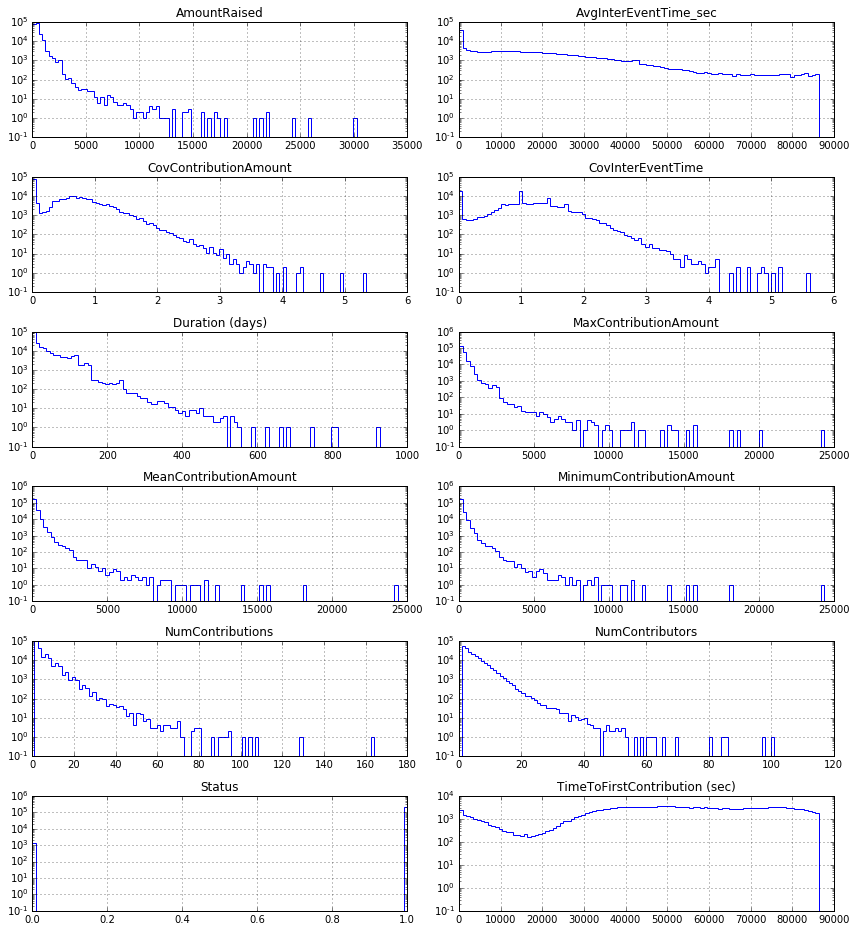

In [17]:
data[lender_features].apply(pd.to_numeric, errors='coerce').hist(figsize=(12,15), 
                                                                layout=(7,2), 
                                                                histtype='step', 
                                                                bins=100, 
                                                                log=True)
plt.grid()
plt.tight_layout()
plt.show()

# Model Evaluation

In [18]:
features_crowd = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)"]

In [19]:
features_platform = ["school_metro", "primary_focus_area", "grade_level", "resource_type", "teacher_prefix", "AmountRequested"]

In [20]:
features_all = features_crowd + features_platform

In [21]:
Counter(data['Status'])

Counter({0: 1295, 1: 214530})

## Class Balancing

In [22]:
# Separate majority and minority classes
df_majority = data[data.Status==1]
df_minority = data[data.Status==0]
print len(df_majority), len(df_minority)

214530 1295


In [23]:
# Down-sample majority class
df_majority_downsampled = resample(df_majority,
                                  replace = False,
                                  n_samples = 1295,
                                  random_state = 42)

In [24]:
# Combine minority class with down-sampled majority class
downsampled = pd.concat([df_majority_downsampled, df_minority])
print Counter(downsampled.Status)
downsampled.sample(5)

Counter({0: 1295, 1: 1295})


,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,AvgInterEventTime_sec,CovInterEventTime,ProjectID,NumContributions,NumContributors,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days)
278869,240.200,240.200,240.200,0.000,nan,nan,ffa5b4e34bb5665f3bc3f133858f6dc8,1,1,240.200,1,204.170,3.000,4,1,4,4,4,75579,1.000
36194,424.390,424.390,424.390,0.000,nan,nan,20e7ed8740d745620fecf119a7b621cf,1,1,424.390,0,348.410,3.000,4,0,2,1,5,52630,125.000
43213,25.000,59.282,141.380,0.688,10381.500,1.462,276f9ea9ae0ad7aa05e9cb4fc14b3ac8,9,7,533.540,0,453.510,3.000,4,1,1,1,5,66628,55.000
255513,5.000,65.515,194.060,1.147,21622.333,1.375,ea2691a3c5959e9806fe64fbde4af3b2,4,4,262.060,1,222.750,3.000,2,1,4,2,4,63276,75.000
172274,5.000,36.887,119.320,1.039,18714.000,1.257,9e3af9ebc0b04943e8293af6b1fc2695,6,6,221.320,0,188.120,3.000,4,1,4,1,4,74433,111.000


### CEM Data Preparation

In [25]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
# CEM variables
cem_features = features_all + ["Status"]

In [26]:
cem = scaler.fit_transform(downsampled[cem_features].fillna(-1))
cem = pd.DataFrame(cem)
cem.columns = cem_features
cem.to_csv("../Data/charity_cem.csv", index=False)
print Counter(cem["Status"])
cem.head()

Counter({0.0: 1295, 1.0: 1295})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),school_metro,primary_focus_area,grade_level,resource_type,teacher_prefix,AmountRequested,Status
0,0.139,0.749,0.502,0.874,0.025,1.000,0.833,0.000,0.800,0.600,0.084,1.000
1,0.083,0.499,0.242,0.616,0.022,0.000,0.500,0.667,0.000,0.600,0.080,1.000
2,0.111,0.472,0.204,0.452,0.002,0.333,0.500,0.000,0.000,0.600,0.040,1.000
3,0.028,0.270,0.007,0.593,0.020,0.667,0.667,1.000,0.200,0.600,0.031,1.000
4,0.028,0.270,0.000,0.317,0.007,1.000,0.500,0.000,0.000,0.800,0.067,1.000


## Evaluation Results

In [27]:
X = downsampled[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = downsampled['Status'].as_matrix()

In [28]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.0170249938965 seconds
Completed CART in 0.0458130836487 seconds
Completed GNB in 0.00920701026917 seconds
Completed RF in 0.189990997314 seconds
Completed LR in 0.0213239192963 seconds
Completed ADB in 0.670732021332 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.666,0.760,0.486,0.593,0.666
1,CART,0.632,0.633,0.631,0.632,0.632
2,GNB,0.665,0.739,0.511,0.604,0.665
3,RF,0.701,0.729,0.639,0.681,0.701
4,LR,0.722,0.706,0.760,0.732,0.722
5,ADB,0.730,0.742,0.703,0.722,0.730


## PIMP

In [29]:
reload(rfpimp)
from rfpimp import *
piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
piRF

,Importance
Feature,
Duration (days),0.127
NumContributors,0.025
CovInterEventTime,0.018
teacher_prefix,0.011
school_metro,0.005
AmountRequested,0.004
grade_level,0.003
primary_focus_area,0.003
resource_type,-0.002


In [30]:
piRF_summary = defaultdict(list)
for i in tqdm_notebook(range(1,10000)):
    reload(rfpimp)
    from rfpimp import *
    piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
    for feature, pi in zip(piRF.Importance.index, piRF.Importance.values):
            piRF_summary[feature].append(pi)

In [31]:
df_piRF = pd.DataFrame()
for feature in features_all:
    df_piRF[feature] = piRF_summary[feature]
df_piRF.to_csv("../Data/dc_permutation_importance.csv", index=False)
df_piRF.head(5)

,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),school_metro,primary_focus_area,grade_level,resource_type,teacher_prefix,AmountRequested
0,0.012,0.007,0.002,-0.003,0.107,-0.005,-0.005,0.005,0.003,0.003,-0.004
1,0.022,0.028,0.029,0.003,0.139,-0.005,0.004,-0.001,0.003,0.003,0.006
2,0.028,0.019,0.008,-0.008,0.125,-0.004,-0.005,-0.003,0.002,0.002,-0.001
3,0.024,0.025,0.028,-0.009,0.134,0.005,0.003,0.003,0.003,-0.000,0.008
4,0.033,0.018,0.033,0.013,0.118,-0.001,0.007,0.003,0.011,0.001,0.011


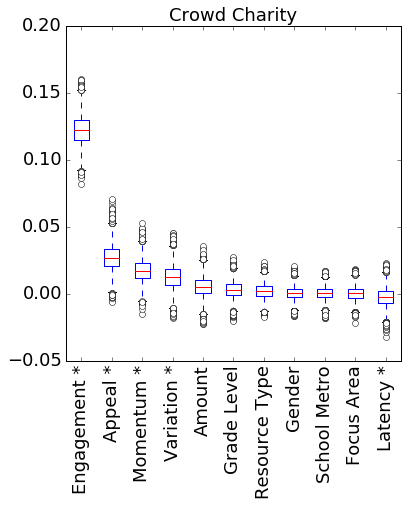

In [58]:
charity_variables = ["Duration (days)", "NumContributors", "CovInterEventTime", "CovContributionAmount", "AmountRequested", "grade_level", "resource_type", "teacher_prefix", "school_metro", "primary_focus_area", "TimeToFirstContribution (sec)"]
charity_labels = ["Engagement *", "Appeal *", "Momentum *", "Variation *", 'Amount', "Grade Level", 'Resource Type', "Gender", "School Metro", "Focus Area", "Latency *"]
red_square = dict(markerfacecolor='w', marker='o')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')
ax = df_piRF[charity_variables].plot.box(figsize=(6,6), rot='vertical', fontsize=18, 
                     flierprops=red_square, 
                     medianprops=medianprops)
ax.set_xticklabels(charity_labels)
plt.title("Crowd Charity", fontsize=18)
plt.show()

# -------------------------------------- End Main ----------------------------------------

# Supplementary

## Crowd Model

In [34]:
X = data[features_crowd].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status'].as_matrix()

In [35]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.252279043198 seconds
Completed CART in 2.68603897095 seconds
Completed GNB in 0.290022134781 seconds
Completed RF in 7.84274506569 seconds
Completed LR in 1.08806610107 seconds
Completed ADB in 18.9098820686 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.985,0.994,0.991,0.993,0.526
1,CART,0.988,0.994,0.994,0.994,0.504
2,GNB,0.984,0.994,0.990,0.992,0.529
3,RF,0.993,0.994,0.999,0.996,0.500
4,LR,0.994,0.994,1.000,0.997,0.500
5,ADB,0.994,0.994,1.000,0.997,0.500


In [36]:
frank_summary(X, y, features_crowd)

Feature ranking completed in 3.92674088478 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,TimeToFirstContribution (sec),1,True,0.609,4
1,CovContributionAmount,1,True,0.186,3
2,Duration (days),1,True,0.122,5
3,CovInterEventTime,1,True,0.072,2
4,NumContributors,1,True,0.012,1


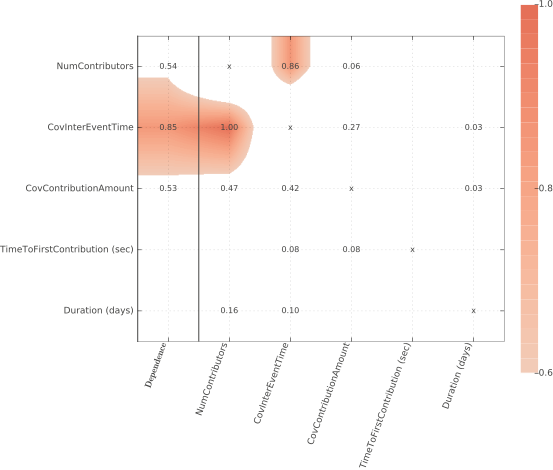

In [37]:
D = feature_dependence_matrix(data[features_crowd].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## Platform Model

In [38]:
X = data[features_platform].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status']
y = np.nan_to_num(y)

In [39]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.31644487381 seconds
Completed CART in 2.08025312424 seconds
Completed GNB in 0.315181970596 seconds
Completed RF in 5.24310207367 seconds
Completed LR in 0.933537960052 seconds
Completed ADB in 13.1868817806 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.994,0.994,1.000,0.997,0.500
1,CART,0.987,0.994,0.993,0.994,0.500
2,GNB,0.994,0.994,1.000,0.997,0.500
3,RF,0.991,0.994,0.997,0.996,0.499
4,LR,0.994,0.994,1.000,0.997,0.500
5,ADB,0.994,0.994,1.000,0.997,0.500


In [40]:
frank_summary(X, y, features_platform)

Feature ranking completed in 2.55787491798 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,AmountRequested,1,True,0.916,6
1,primary_focus_area,1,True,0.027,2
2,school_metro,1,True,0.016,1
3,resource_type,1,True,0.015,4
4,teacher_prefix,1,True,0.014,5
5,grade_level,1,True,0.013,3


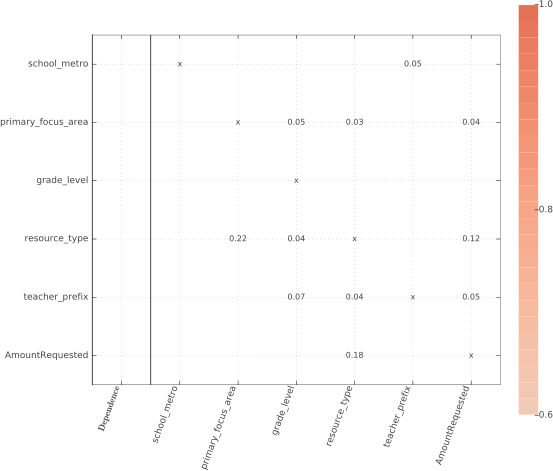

In [41]:
D = feature_dependence_matrix(data[features_platform].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## All Features

In [42]:
X = data[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status']
y = np.nan_to_num(y)

In [43]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.453475952148 seconds
Completed CART in 4.55181217194 seconds
Completed GNB in 0.372158050537 seconds
Completed RF in 8.43993711472 seconds
Completed LR in 1.58749294281 seconds
Completed ADB in 27.3698501587 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.985,0.994,0.991,0.993,0.528
1,CART,0.987,0.994,0.992,0.993,0.512
2,GNB,0.983,0.994,0.989,0.992,0.530
3,RF,0.994,0.994,1.000,0.997,0.500
4,LR,0.994,0.994,1.000,0.997,0.500
5,ADB,0.994,0.994,1.000,0.997,0.500


In [44]:
summary = frank_summary(X, y, features_all)
summary

Feature ranking completed in 4.27980208397 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,TimeToFirstContribution (sec),1,True,0.243,4
1,AmountRequested,1,True,0.238,11
2,Duration (days),1,True,0.157,5
3,CovContributionAmount,1,True,0.111,3
4,primary_focus_area,1,True,0.048,7
5,CovInterEventTime,1,True,0.047,2
6,resource_type,1,True,0.037,9
7,school_metro,1,True,0.036,6
8,grade_level,1,True,0.032,8
9,teacher_prefix,1,True,0.031,10


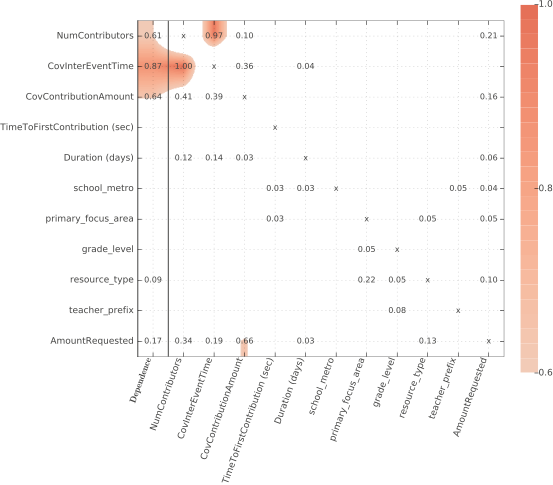

In [45]:
D = feature_dependence_matrix(data[features_all].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## CEM Analysis

In [46]:
cem = pd.read_csv("../Data/cem_results.csv")
cem = cem.drop(['Unnamed: 0'], axis=1)
cem = cem.astype('str')
cem.head()

,school_metro,primary_focus_area,grade_level,resource_type,teacher_prefix,AmountRequested
0,4,6,1,5,3,2
1,1,4,3,1,3,1
2,2,4,1,1,3,1
3,3,5,4,2,3,1
4,4,4,1,1,4,1


In [47]:
data["cem"] = cem.apply(lambda x: ''.join(x), axis=1)
data.head()

,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,AvgInterEventTime_sec,CovInterEventTime,ProjectID,NumContributions,NumContributors,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days),cem
0,10.000,226.760,595.280,1.155,34329.000,0.277,00002eb25d60a09c318efbd0797bffb5,3,3,680.280,1,590.990,0.000,6,1,2,3,2,77100,93.000,461532
1,10.000,72.457,174.660,0.726,30393.857,0.829,00005f52c98eeaf92b2414a352b023a4,8,7,579.660,1,507.710,3.000,4,0,2,4,5,224,59.000,143131
2,3.000,28.045,50.000,0.517,18743.357,1.095,0000c0bdc0f15bd239cfffa884791a10,15,15,420.680,1,361.030,3.000,5,0,4,3,5,72103,9.000,241131
4,258.460,258.460,258.460,0.000,nan,nan,0000d2308ba8cb5474dd80ccb920547a,1,1,258.460,1,219.690,3.000,4,1,2,4,5,69578,21.000,441141
6,188.300,188.300,188.300,0.000,0.000,nan,00012e7f0fe1c81ea915d97febd73111,2,2,376.600,1,327.640,0.000,4,0,1,1,4,52924,123.000,231432


In [48]:
funded_cem = data[data.Status == True]
print len(funded_cem)
funded_cem.head()

214530


,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,AvgInterEventTime_sec,CovInterEventTime,ProjectID,NumContributions,NumContributors,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days),cem
0,10.000,226.760,595.280,1.155,34329.000,0.277,00002eb25d60a09c318efbd0797bffb5,3,3,680.280,1,590.990,0.000,6,1,2,3,2,77100,93.000,461532
1,10.000,72.457,174.660,0.726,30393.857,0.829,00005f52c98eeaf92b2414a352b023a4,8,7,579.660,1,507.710,3.000,4,0,2,4,5,224,59.000,143131
2,3.000,28.045,50.000,0.517,18743.357,1.095,0000c0bdc0f15bd239cfffa884791a10,15,15,420.680,1,361.030,3.000,5,0,4,3,5,72103,9.000,241131
4,258.460,258.460,258.460,0.000,nan,nan,0000d2308ba8cb5474dd80ccb920547a,1,1,258.460,1,219.690,3.000,4,1,2,4,5,69578,21.000,441141
6,188.300,188.300,188.300,0.000,0.000,nan,00012e7f0fe1c81ea915d97febd73111,2,2,376.600,1,327.640,0.000,4,0,1,1,4,52924,123.000,231432


In [49]:
unfunded_cem = data[data.Status == False]
print len(unfunded_cem)
unfunded_cem.head()

1295


,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,AvgInterEventTime_sec,CovInterEventTime,ProjectID,NumContributions,NumContributors,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days),cem
61,50.000,179.635,309.270,0.722,31940.000,0.000,000da041f12f39b41a29cb43eaed90c1,2,2,359.270,0,305.380,2.000,4,1,1,2,5,46600,70.000,161332
598,638.820,638.820,638.820,0.000,nan,nan,0093944b42515aa723b06a98116954b4,1,1,638.820,0,562.000,2.000,4,1,4,3,4,77198,211.000,442341
905,102.320,102.320,102.320,0.000,0.000,nan,00dde2d3a00e7fc5db44caa6d86062f3,2,2,204.640,0,173.940,2.000,5,3,1,4,5,65044,58.000,451421
1260,549.850,549.850,549.850,0.000,nan,nan,012f1182d2892566c827f770533a7ccf,1,1,549.850,0,466.000,3.000,4,1,4,3,5,29402,198.000,332431
1396,691.920,691.920,691.920,0.000,nan,nan,014f1c9a3be14a6373e1a1472a80a57b,1,1,691.920,0,600.000,3.000,4,1,4,4,5,76512,118.000,342131


In [50]:
unfunded_matched = unfunded_cem[unfunded_cem["cem"].isin(funded_cem["cem"])]
print len(unfunded_matched)
unfunded_matched.head()

1290


,MinimumContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,AvgInterEventTime_sec,CovInterEventTime,ProjectID,NumContributions,NumContributors,AmountRaised,Status,AmountRequested,school_metro,primary_focus_area,poverty_level,grade_level,resource_type,teacher_prefix,TimeToFirstContribution (sec),Duration (days),cem
61,50.000,179.635,309.270,0.722,31940.000,0.000,000da041f12f39b41a29cb43eaed90c1,2,2,359.270,0,305.380,2.000,4,1,1,2,5,46600,70.000,161332
598,638.820,638.820,638.820,0.000,nan,nan,0093944b42515aa723b06a98116954b4,1,1,638.820,0,562.000,2.000,4,1,4,3,4,77198,211.000,442341
905,102.320,102.320,102.320,0.000,0.000,nan,00dde2d3a00e7fc5db44caa6d86062f3,2,2,204.640,0,173.940,2.000,5,3,1,4,5,65044,58.000,451421
1396,691.920,691.920,691.920,0.000,nan,nan,014f1c9a3be14a6373e1a1472a80a57b,1,1,691.920,0,600.000,3.000,4,1,4,4,5,76512,118.000,342131
1992,231.380,231.380,231.380,0.000,nan,nan,01d364f9817cb790a3cb1e10ef0d209a,1,1,231.380,0,196.670,0.000,3,1,3,1,2,63965,47.000,441142


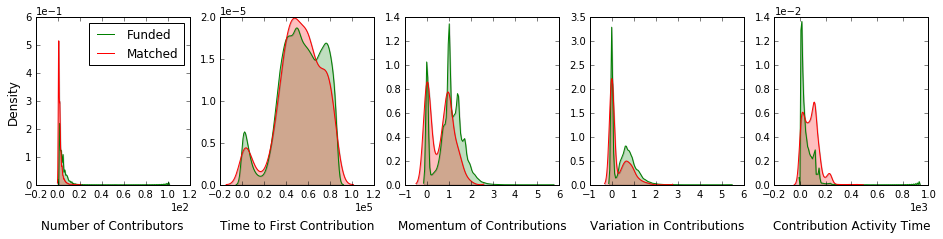

In [51]:
fig = plt.figure(figsize=(16,3))
plt.tick_params(size=12)
b = True
s = 12

plt.subplot(1, 5, 1)
sns.kdeplot(funded_cem["NumContributors"], shade=b, color="g",label="Funded")
sns.kdeplot(unfunded_matched["NumContributors"], shade=b, color="r", label="Matched")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel("Density", size=s)
plt.xlabel("Number of Contributors", size=s, labelpad=20)
plt.legend(loc=1)

plt.subplot(1, 5, 2)
sns.kdeplot(funded_cem["TimeToFirstContribution (sec)"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["TimeToFirstContribution (sec)"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Time to First Contribution", size=s, labelpad=20)

plt.subplot(1, 5, 3)
sns.kdeplot(funded_cem["CovInterEventTime"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["CovInterEventTime"], shade=b, color="r", legend=False)
plt.xlabel("Momentum of Contributions", size=s, labelpad=20)

plt.subplot(1, 5, 4)
sns.kdeplot(funded_cem["CovContributionAmount"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["CovContributionAmount"], shade=b, color="r", legend=False)
plt.xlabel("Variation in Contributions", size=s, labelpad=20)

plt.subplot(1, 5, 5)
sns.kdeplot(funded_cem["Duration (days)"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["Duration (days)"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("Contribution Activity Time", size=s, labelpad=20)

plt.show()

### 2-Sample KS Test

This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the one-sample K-S test, the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

If the K-S statistic is high or the p-value is low, then we can <b>reject the hypothesis that the distributions of the two samples are the same.</b>

In [52]:
print "Appeal:", stats.ks_2samp(funded_cem["NumContributors"], unfunded_cem["NumContributors"])
print "Latency:", stats.ks_2samp(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"])
print "Momentum:", stats.ks_2samp(funded_cem["CovInterEventTime"], unfunded_cem["CovInterEventTime"])
print "Variation:", stats.ks_2samp(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"])
print "Duration:", stats.ks_2samp(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"])

Appeal: Ks_2sampResult(statistic=0.28285453681901734, pvalue=1.7098007659661026e-90)
Latency: Ks_2sampResult(statistic=0.04702487812542344, pvalue=0.006480366922798946)
Momentum: Ks_2sampResult(statistic=0.22807338372993524, pvalue=5.52083243317132e-59)
Variation: Ks_2sampResult(statistic=0.24466947319695187, pvalue=8.122184505072082e-68)
Duration: Ks_2sampResult(statistic=0.4313939226399022, pvalue=6.26410397859108e-210)


### Student T-Test

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [53]:
print "Appeal:", stats.ttest_ind(funded_cem["NumContributors"], unfunded_cem["NumContributors"], equal_var=False)
print "Latency:", stats.ttest_ind(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"], equal_var=False)
print "Momentum:", stats.ttest_ind(funded_cem["CovInterEventTime"].dropna(), unfunded_cem["CovInterEventTime"].dropna(), equal_var=False)
print "Variation:", stats.ttest_ind(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"], equal_var=False)
print "Duration:", stats.ttest_ind(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"], equal_var=False)

Appeal: Ttest_indResult(statistic=31.51550744043856, pvalue=9.53176442823282e-164)
Latency: Ttest_indResult(statistic=1.7581071902724983, pvalue=0.0789627662310353)
Momentum: Ttest_indResult(statistic=16.006339980877517, pvalue=5.362272211206036e-47)
Variation: Ttest_indResult(statistic=17.98322442705579, pvalue=8.046113601792748e-65)
Duration: Ttest_indResult(statistic=-29.88141662189334, pvalue=7.666568142993461e-150)


## Feature Correlations

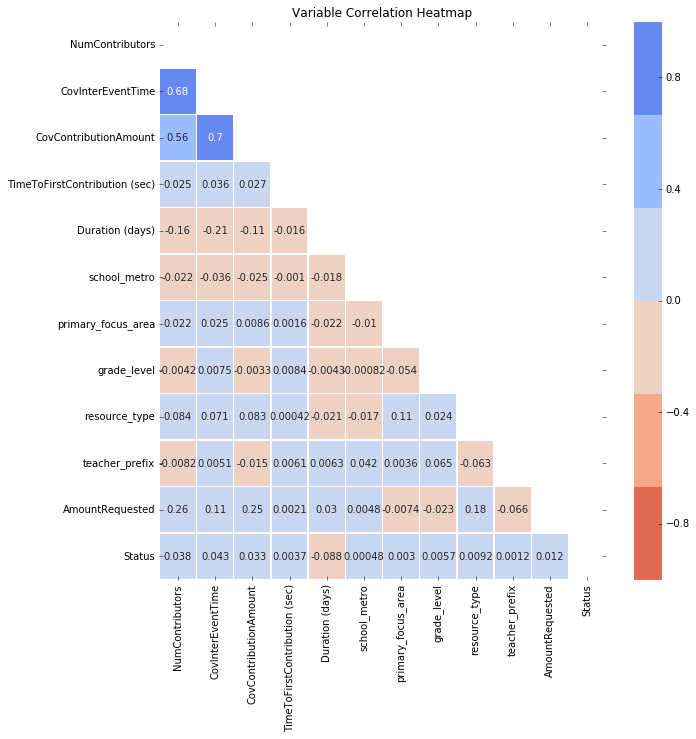

In [54]:
corr = data[features_all+["Status"]].fillna(-1).corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

In [55]:
print stats.pearsonr(data.Status, data.NumContributors)
print stats.pearsonr(data.Status, data.CovInterEventTime)
print stats.pearsonr(data.Status, data.CovContributionAmount)
print stats.pearsonr(data.Status, data['TimeToFirstContribution (sec)'])
print stats.pearsonr(data.Status, data['Duration (days)'])

(0.03760818505284102, 2.11858123353323e-68)
(nan, 1.0)
(0.0333326124890914, 4.082277066758184e-54)
(0.0037373780464111865, 0.08251635608568735)
(-0.08800871638202853, 0.0)


In [56]:
momentum_ = data[["Status", "CovInterEventTime"]].dropna()
print stats.pearsonr(momentum_.Status, momentum_.CovInterEventTime)

(0.0401617728112738, 1.2062667127665538e-48)
